<a href="https://colab.research.google.com/github/aylinkarapanar/benchmark/blob/main/Gemma_connections_benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Downloads & Imports

In [9]:
#Downloads
%pip install torch torchvision torchaudio #installs the deep learning library
%pip install transformers -U # Transformer library serves as the backend for running LLMs
%pip install sentencepiece # Embeddings with LLMs - also needed
%pip install accelerate # Accelarates running LLMs through some tricks - produced by Meta but open-source and maintainers usually from HF
%pip install huggingface_hub # The HF Hub
%pip install langchain # Langchain
%pip install pandas
%pip install langchain-huggingface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.7/224.7 kB 2.1 MB/s eta 0:00:00


In [11]:
#Imports
import os
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import time
from langchain_huggingface import HuggingFacePipeline
from langchain.output_parsers import ResponseSchema
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.exceptions import OutputParserException

#mounting google drive to store the results dataframe as csv
from google.colab import drive
drive.mount('drive')

Mounted at drive


# The Connections DataFrame

In [16]:
#Getting the data
github_url = "https://raw.githubusercontent.com/Eyefyre/NYT-Connections-Answers/c1259fe799fce026358998a6aff4906e4ef243d6/connections.json"
response = requests.get(github_url)
data = response.json()

# Define columns for the DataFrame
columns = ["id"]
for i in range(1, 5):
    columns.extend([f"group{i}_name", f"group{i}_members1", f"group{i}_members2", f"group{i}_members3", f"group{i}_members4"])

#Create an empty DataFrame from the defined column names
df = pd.DataFrame(columns=columns)

#Iterate through the data (JSON format) and store the necessary information in the dataframe
rows = []
for entry in data:
    row = {"id": entry["id"]}
    for i, answer in enumerate(entry["answers"]):
        row[f"group{i+1}_name"] = answer["group"].lower()
        members = answer["members"]
        row[f"group{i+1}_members1"] = members[0].lower()
        row[f"group{i+1}_members2"] = members[1].lower()
        row[f"group{i+1}_members3"] = members[2].lower()
        row[f"group{i+1}_members4"] = members[3].lower()
    rows.append(row)

# Concatenate the rows into the DataFrame
df = pd.concat([df, pd.DataFrame(rows)], ignore_index=True)

#Exclude the entry from 1st of April 2024, because it includes an April Fool's joke where NYT changed the format of the game to include emojis
df = df[df['id'] != 295]

In [ ]:
#Display the dataframe
df

#Functions for the Execution of the Benchmark

In [ ]:
#function for output formatting, defining temperatures, and templates of the query

def process_data(data_df, temperature_value, template_format):

    # Define the Large Language Model and the temperature
    llm = HuggingFaceHub(repo_id="google/gemma-1.1-7b-it", model_kwargs={"temperature": temperature_value})

    # Define response schemas, the output is expected be in a dictionary format
    response_schemas = [
        ResponseSchema(name="group1_members", description="this will be a comma separated list of 4 words (only words)"),
        ResponseSchema(name="group2_members", description="this will be a comma separated list of 4 words (only words)"),
        ResponseSchema(name="group3_members", description="this will be a comma separated list of 4 words (only words)"),
        ResponseSchema(name="group4_members", description="this will be a comma separated list of 4 words (only words)"),
    ]

    # Define output parser
    output_parser = JsonOutputParser()

    # Define prompt template
    prompt = PromptTemplate(
        template=template_format,
        input_variables=["question"],
        partial_variables={"format_instructions": output_parser.get_format_instructions()},
    )

    result_dfs = []

    # Define function to process each row
    def process_row(row):

        #Get the members of each group and put them in a list
        row_members = [row[f"group{i}_members{j}"] for i in range(1, 5) for j in range(1, 5)]
        #Set seed for shuffling
        #(the reason for doing this is that the randomness of shuffling creates different responses and we wanted eliminate it as much as possible)
        random.seed(1)
        #Shuffle the members
        random.shuffle(row_members)
        #Define the chain
        chain = prompt | llm | output_parser

        #Try block to handle potential exceptions during the chain invocation
        try:
            #Invoke the chain with the shuffled list of members
            llm_grouping = chain.invoke({"question": row_members}) or {}

            #If the grouping is a list which not the desired format, return an empty dataframe
            if isinstance(llm_grouping, list):
                return pd.DataFrame([""] * len(row), index=row.index).T

            #If the grouping is in the desired format, separate the data and create a dataframe
            separated_data = {}
            for i, (group_name, members) in enumerate(llm_grouping.items(), start=1):
                for j, member in enumerate(members, start=1):
                    column_name = f"group{i}_members{j}"
                    separated_data[column_name] = member
            llm_grouping_df = pd.DataFrame([separated_data])
            return llm_grouping_df

        #If there is an expection with the OutputParser, return an empty dataframe
        except OutputParserException as e:
            return pd.DataFrame([""] * len(row), index=row.index).T

    # Process each row in the DataFrame
    for _, row in data_df.iterrows():
        result_df = process_row(row)
        result_dfs.append(result_df if not result_df.empty else pd.DataFrame())

    # Concatenate the result DataFrames
    result_df = pd.concat(result_dfs, ignore_index=True)

    # Select only columns starting with 'group'
    selected_columns = [col for col in result_df.columns if col.startswith('group')]
    result_df = result_df[selected_columns]

    return result_df


In [21]:
#Function for calculating the difference between llm groupings and the answers

def compare_grouping_df(answers_df, llm_df):

    total_score = 0
    # Iterate over each row of both answers and llm dataframes
    for index, (answers_row, llm_row) in enumerate(zip(answers_df.iterrows(), llm_df.iterrows())):
        # Initialize score for the current row to 0
        score = 0

        _, answers_row = answers_row
        _, llm_row = llm_row

        # Loop over each of the four groups
        for i in range(1, 5):
            # Initialize a list to store the members
            llm_group_members = []

            # Loop over each member of the llm grouping and store it in the list
            for j in range(1, 5):
                llm_group_members.append(llm_row[f'group{i}_members{j}'])

            # Loop over each member in the answers and store it in the list
            for k in range(1, 5):
                selected_group_members = []
                for group_col in answers_row.filter(regex=f'group{k}_members.*').index:
                    selected_group_members.append(answers_row[group_col])

                # Count the number of matching members between llm grouping and answer group
                matched_count = sum(1 for word in llm_group_members if word in selected_group_members)

                # Update the score based on the number of matches per group
                if matched_count == 4:
                    score += 3
                elif matched_count == 3:
                    score += 2
                elif matched_count == 2:
                    score += 1
        total_score += score

    # Calculate the total possible score based on the number of rows and possible points per row
    total_possible_score = len(answers_df) * 12

    # Calculate the accuracy percentage
    accuracy_percentage = (total_score / total_possible_score) * 100

    return accuracy_percentage

#Defining Test Parameters

In [13]:
# Define temperatures and the templates
temperatures = [0.25, 0.5, 0.75, 1, 1.25, 1.5]

template_names = ["template_NYT", "template_NYT_example", "template_altered", "template_altered_example"]

templates = {
    "template_NYT": "Find groups of four items that share something in common. Select four items per group. There are four groups in total. Each puzzle has exactly one solution. Every word is used a single time. Here are the words that needs to be grouped: \n{format_instructions}\n{question}",

    "template_NYT_example": """Find groups of four items that share something in common. Select four items per group. There are four groups in total.
                          Each puzzle has exactly one solution. Every word is used a single time.
                          Here is an example grouping:
                          group1: fancy, love, relish, savor;
                          group2: like, literally, um, well;
                          group3: cylinder, pin, spring, tumbler
                          group4: carrot, hurts, jewel, om
                          Here are the words that needs to be grouped: \n{format_instructions}\n{question}""",

    "template_altered": """Discover sets of four items that exhibit a common trait. Choose four items for each set. There are four sets in total.
                      Each puzzle has precisely one solution. Every word must be used exactly once.
                      Here are the words to be organized:\n{format_instructions}\n{question}""",

    "template_altered_example": """Discover sets of four items that exhibit a common trait. Choose four items for each set. There are four sets in total.
                              Each puzzle has precisely one solution. Every word must be used exactly once.
                              Here is an example grouping:
                              group1: fancy, love, relish, savor;
                              group2: like, literally, um, well;
                              group3: cylinder, pin, spring, tumbler
                              group4: carrot, hurts, jewel, om
                              Here are the words to be organized:\n{format_instructions}\n{question}"""
}


In [17]:
# Define the rows that are to be tested
df_sampled = df[:100]

In [14]:
#creating a dataframe to store the accuracy score of each combination
accuracy_df = pd.DataFrame(index=template_names, columns=temperatures)

#Testing

In [ ]:
# Define the tokens
tokens = [
    {"HUGGINGFACEHUB_API_TOKEN" : "00", "HF_TOKEN" : "00"},
    {"HUGGINGFACEHUB_API_TOKEN" : "01", "HF_TOKEN" : "01"}
]

token_index = 0
combinations_counter = 0
total_iterations_per_token = 3
max_iterations = len(temperatures) * len(template_names)

# Run the loop for a maximum of 6 iterations per token
while combinations_counter < max_iterations:
    for temperature in temperatures:
        for template_name in template_names:
          token = tokens[token_index]

          os.environ["HUGGINGFACEHUB_API_TOKEN"] = token["HUGGINGFACEHUB_API_TOKEN"]
          os.environ["HF_TOKEN"] = token["HF_TOKEN"]

          # Process data with the selected token
          result_df = process_data(df_sampled, temperature, templates[template_name])
          accuracy_percentage = compare_grouping_df(df_sampled, result_df)

          # Save the result to CSV
          file_name = f"result_{temperature}_{template_name}.csv"
          result_df.to_csv(file_name)
          !cp $file_name "drive/My Drive/"

          # Store accuracy percentage in the dataframe
          accuracy_df.at[template_name, temperature] = accuracy_percentage

          # Check if three combinations for the current token have been processed
          # And switch to the next token if necessary
          if (combinations_counter > 0) and (combinations_counter % total_iterations_per_token == 0):
              token_index = (token_index + 1) % len(tokens)

          combinations_counter += 1
          print(token_index, combinations_counter)
          print(temperature, template_name, accuracy_percentage)
          # Check if six combinations have been processed
          if combinations_counter > 0 and combinations_counter % (len(tokens) * total_iterations_per_token) == 0:
              # Wait for an hour
              print("Waiting for an hour...")
              time.sleep(3600)


          time.sleep(10)

            # If maximum iterations have been reached, break out of the loops
          if combinations_counter >= max_iterations:
              break
        if combinations_counter >= max_iterations:
            break

#Results & Visualisations



In [18]:
# Github link for dataframes for each temperature & template
!git clone https://github.com/aylinkarapanar/benchmark


Cloning into 'benchmark'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 41 (delta 17), reused 29 (delta 11), pack-reused 0
Receiving objects: 100% (41/41), 184.54 KiB | 2.37 MiB/s, done.
Resolving deltas: 100% (17/17), done.


In [19]:
!ls benchmark/result_dataframes

result_0.25_template_altered.csv	  result_1.25_template_altered.csv
result_0.25_template_altered_example.csv  result_1.25_template_altered_example.csv
result_0.25_template_NYT.csv		  result_1.25_template_NYT.csv
result_0.25_template_NYT_example.csv	  result_1.25_template_NYT_example.csv
result_0.5_template_altered.csv		  result_1.5_template_altered.csv
result_0.5_template_altered_example.csv   result_1.5_template_altered_example.csv
result_0.5_template_NYT.csv		  result_1.5_template_NYT.csv
result_0.5_template_NYT_example.csv	  result_1.5_template_NYT_example.csv
result_0.75_template_altered.csv	  result_1_template_altered.csv
result_0.75_template_altered_example.csv  result_1_template_altered_example.csv
result_0.75_template_NYT.csv		  result_1_template_NYT.csv
result_0.75_template_NYT_example.csv	  result_1_template_NYT_example.csv


In [22]:
# Loop through the CSV files
for temperature in temperatures:
    for template_name in template_names:
        # Load the CSV file
        file_path = f"benchmark/result_dataframes/result_{temperature}_{template_name}.csv"
        df = pd.read_csv(file_path)

        # Calculate accuracy score
        accuracy_percentage = compare_grouping_df(df_sampled, df)

        # Record accuracy score in the accuracy_df DataFrame
        accuracy_df.at[template_name, temperature] = accuracy_percentage

In [23]:
# Display the accuracy_df DataFrame
accuracy_df

,0.25,0.50,0.75,1.00,1.25,1.50
template_NYT,48.0,42.666667,41.25,50.75,33.25,28.166667
template_NYT_example,46.333333,44.5,41.0,46.0,36.833333,33.083333
template_altered,53.583333,54.25,52.916667,53.416667,40.666667,35.333333
template_altered_example,34.25,30.166667,28.583333,43.25,23.083333,8.666667


In [ ]:
# Save the accuracy_df to Drive
accuracy_df.to_csv('accuracy_df.csv')
!cp accuracy_df.csv "drive/My Drive/"

## Performance Against Random Shuffling

In [24]:
members_df = df_sampled.drop(columns=['id', 'group1_name', 'group2_name', 'group3_name', 'group4_name'])

#Shuffle members in a row with same seed as before
def shuffle_row_seed(row):
    row_list = list(row)
    random.seed(1)
    random.shuffle(row_list)
    return row_list

# Apply the shuffle_row_seed function to each row of the DataFrame and expand the result
df_shuffled_seed = members_df.apply(shuffle_row_seed, axis=1, result_type='expand')

# Rename the columns of the shuffled DataFrame
df_shuffled_seed.columns = [f"group{i}_members{j}" for i in range(1, 5) for j in range(1, 5)]

In [25]:
# Shuffle members in a row randomly for every row
def shuffle_row(row):
    row_list = list(row)
    random.shuffle(row_list)
    return row_list

df_shuffled = members_df.apply(shuffle_row, axis=1, result_type='expand')

df_shuffled.columns = [f"group{i}_members{j}" for i in range(1, 5) for j in range(1, 5)]

In [26]:
# Evaluation of random grouping

same_shuffling_score = compare_grouping_df(df_sampled, df_shuffled_seed)
random_shuffling_score = compare_grouping_df(df_sampled, df_shuffled)

print(same_shuffling_score)
print(random_shuffling_score)

25.0
37.916666666666664


## Heatmap

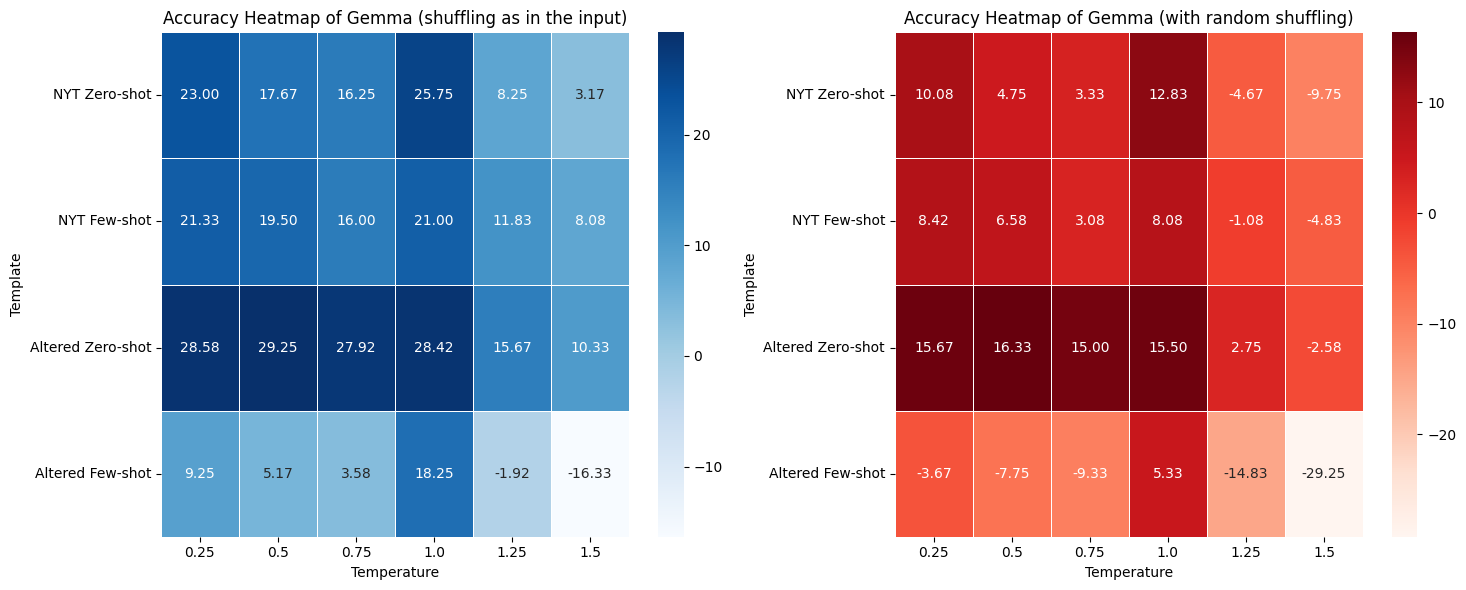

In [38]:
# Define your custom labels
custom_labels = {
    'template_NYT': 'NYT Zero-shot',
    'template_NYT_example': 'NYT Few-shot',
    'template_altered': 'Altered Zero-shot',
    'template_altered_example': 'Altered Few-shot'
}

cmap1 = sns.color_palette("Blues", as_cmap=True)
cmap2 = sns.color_palette("Reds", as_cmap=True)

# Side-by-side heatmaps
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Round the accuracy percentages
accuracy_df_numeric = accuracy_df.astype(float)
accuracy_df_rounded = accuracy_df_numeric.round(3)

# Compare the df to the shuffling with seed
sns.heatmap(accuracy_df_rounded - same_shuffling_score, annot=True, fmt=".2f", cmap=cmap1, linewidths=.5, ax=axes[0])
axes[0].set_title('Accuracy Heatmap of Gemma (shuffling as in the input)')
axes[0].set_xlabel('Temperature')
axes[0].set_ylabel('Template')

# Compare it to the random shuffling
sns.heatmap(accuracy_df_rounded - random_shuffling_score, annot=True, fmt=".2f", cmap=cmap2, linewidths=.5, ax=axes[1])
axes[1].set_title('Accuracy Heatmap of Gemma (with random shuffling)')
axes[1].set_xlabel('Temperature')
axes[1].set_ylabel('Template')

# Set custom labels for y-axisc
axes[0].set_yticklabels([custom_labels[label] for label in accuracy_df.index])
axes[1].set_yticklabels([custom_labels[label] for label in accuracy_df.index])

plt.tight_layout()

output_path = 'drive/My Drive/accuracy_heatmaps.png'
plt.savefig(output_path)

plt.show()


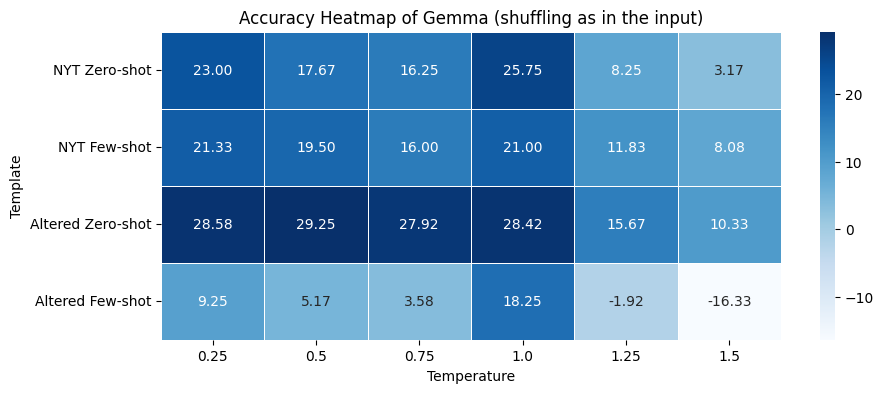

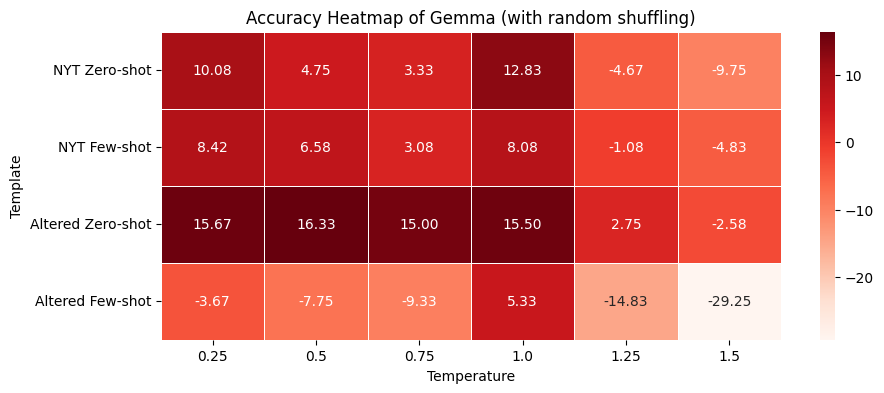

In [37]:
# Create the first heatmap
fig, ax = plt.subplots(figsize=(10, len(accuracy_df) * 1))
sns.heatmap(accuracy_df_rounded - same_shuffling_score, annot=True, fmt=".2f", cmap=cmap1, linewidths=.5, ax=ax)
ax.set_title('Accuracy Heatmap of Gemma (shuffling as in the input)')
ax.set_xlabel('Temperature')
ax.set_ylabel('Template')
ax.set_yticklabels([custom_labels[label] for label in accuracy_df.index])

# Save the first heatmap
output_path1 = 'drive/My Drive/accuracy_heatmap_shuffling_input.png'
plt.savefig(output_path1, bbox_inches='tight')

# Create the second heatmap
fig, ax = plt.subplots(figsize=(10, len(accuracy_df) * 1))
sns.heatmap(accuracy_df_rounded - random_shuffling_score, annot=True, fmt=".2f", cmap=cmap2, linewidths=.5, ax=ax)
ax.set_title('Accuracy Heatmap of Gemma (with random shuffling)')
ax.set_xlabel('Temperature')
ax.set_ylabel('Template')
ax.set_yticklabels([custom_labels[label] for label in accuracy_df.index])

# Save the second heatmap
output_path2 = 'drive/My Drive/accuracy_heatmap_random_shuffling.png'
plt.savefig(output_path2, bbox_inches='tight')
